In [1]:
import numpy as np
import pandas as pd
import scipy.sparse 
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\nishk\anaconda3\envs\torch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/Walmart.csv")

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Fix Date and basic date features

In [4]:
# 1. Convert Date to Datetime
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

# Sort again just to be safe for lag features
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

# 2. Add Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Is_Year_End'] = df['Date'].dt.is_year_end.astype(int)
df["is_last_week_of_month"] = (df["Date"] + pd.Timedelta(days=7)).dt.month != df["Date"].dt.month
df['is_mid_of_year'] = (df['Date'].dt.month >= 4) & (df['Date'].dt.month <= 6)
# Time Index (Weeks since start of data)
start_date = df['Date'].min()
df['Time_Idx'] = ((df['Date'] - start_date).dt.days // 7).astype(int)

# Season Mapping {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
def get_season(month):
    if month in [12, 1, 2]: return 0
    elif month in [3, 4, 5]: return 1
    elif month in [6, 7, 8]: return 2
    else: return 3

df['Season'] = df['Month'].apply(get_season)

Holiday distance features

In [5]:
# Get unique holiday dates
holiday_dates = df.loc[df['Holiday_Flag'] == 1, 'Date'].unique()
holiday_dates = np.sort(pd.to_datetime(holiday_dates))

# Helper function to find nearest date
def get_weeks_diff(current_date, dates, direction='forward'):
    if direction == 'forward':
        future_dates = dates[dates >= current_date]
        if len(future_dates) == 0: return 0 # or NaN
        return (future_dates[0] - current_date).days / 7
    else: # backward
        past_dates = dates[dates <= current_date]
        if len(past_dates) == 0: return 0 # or NaN
        return (current_date - past_dates[-1]).days / 7

# Apply (This might take a few seconds)
# Note: merge_asof is faster for large data, but apply is simpler for this size
df['Weeks_To_Next_Holiday'] = df['Date'].apply(lambda x: get_weeks_diff(x, holiday_dates, 'forward'))
df['Weeks_Since_Last_Holiday'] = df['Date'].apply(lambda x: get_weeks_diff(x, holiday_dates, 'backward'))

interaction and economic features

In [6]:
# Unemployment & Holiday interaction
df['Unemployment_Holiday_Combo'] = df['Unemployment'] * df['Holiday_Flag']

# Fuel Price interactions
df['Fuel_Unemployment'] = df['Fuel_Price'] * df['Unemployment']
# "Sudden change" - difference from last week
df['Fuel_Price_Diff'] = df.groupby('Store')['Fuel_Price'].diff().fillna(0)
df['is_month_end_and_high_fuel_price'] = df['is_last_week_of_month'] & (df['Fuel_Price'] > df.groupby('Store')['Fuel_Price'].shift(1))


# CPI Features
# Rolling trend over 4 weeks per store
df['CPI_Trend_4w'] = df.groupby('Store')['CPI'].diff().rolling(4).mean().reset_index(0, drop=True).fillna(0)
df['CPI_Unemployment'] = df['CPI'] * df['Unemployment']
df['CPI_Time_Idx'] = df['CPI'] * df['Time_Idx']

temperature and seasonal features

In [7]:
# Calculate Mean and Std of Temperature per Season
season_stats = df.groupby('Season')['Temperature'].agg(['mean', 'std']).to_dict()

def calculate_temp_zscore(row):
    mean = season_stats['mean'][row['Season']]
    std = season_stats['std'][row['Season']]
    return (row['Temperature'] - mean) / std

df['Temp_ZScore'] = df.apply(calculate_temp_zscore, axis=1)

# Flags for abnormal temps
df['Abnormally_Hot'] = (df['Temp_ZScore'] > 1).astype(int)
df['Abnormally_Cold'] = (df['Temp_ZScore'] < -1).astype(int)

lag features (for target variable:weekly sales)

In [8]:
# Lag 1 week sales
df['Lag_Sales_1w'] = df.groupby('Store')['Weekly_Sales'].shift(1)

# Average of last 4 weeks (excluding current, hence shift(1) first)
df['Rolling_Mean_Sales_4w'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4).mean().reset_index(0, drop=True)

# Drop NaN values created by lags (first 4 weeks will be empty)
df = df.dropna().reset_index(drop=True)

spliting using out of fold technique, added the store target mean encoding, ML model is XGBoost

In [9]:
# Define split dates for expanding window validation
split_dates = [
    pd.Timestamp('2012-02-01'), # Train: ~2010-2011, Test: Early 2012
    pd.Timestamp('2012-06-01'), # Train: ~2010-Mid 2012, Test: Mid-Late 2012
]

# To store metrics and feature importance
metrics_history = []
feature_importance_list = []

# Columns to EXCLUDE from training features
drop_cols = ['Date', 'Weekly_Sales', 'Store']

for split_date in split_dates:
    i = split_dates.index(split_date)
    print(f"\n========== FOLD {i+1}: Split at {split_date} ==========")
    
    # 1. Split Data
    train_data = df[df['Date'] < split_date].copy()
    test_data = df[df['Date'] >= split_date].copy()
    
    if len(test_data) == 0: break
    
    # 2. Target Encoding (Store Mean)
    store_means = train_data.groupby('Store')['Weekly_Sales'].mean().to_dict()
    train_data['Store_Target_Mean'] = train_data['Store'].map(store_means)
    test_data['Store_Target_Mean'] = test_data['Store'].map(store_means)
    
    global_mean = train_data['Weekly_Sales'].mean()
    test_data['Store_Target_Mean'] = test_data['Store_Target_Mean'].fillna(global_mean)

    # 3. Prepare X and y
    X_train = train_data.drop(columns=drop_cols)
    y_train = train_data['Weekly_Sales']
    X_test = test_data.drop(columns=drop_cols)
    y_test = test_data['Weekly_Sales']
    
    # Log transform target
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)
    
    # 4. Train XGBoost Model
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=50
    )
    
    model.fit(
        X_train, y_train_log, 
        eval_set=[(X_train, y_train_log), (X_test, y_test_log)],
        verbose=100
    )
    
    # 5. Predict and Inverse Transform
    preds_log = model.predict(X_test)
    preds = np.expm1(preds_log)
    
    # 6. Evaluate
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds)
    
    print(f"Fold {i+1} Results -> R^2: {r2:.4f} | RMSE: {rmse:,.0f} | MAPE: {mape:.4%}")
    
    metrics_history.append({'Split': split_date, 'R2': r2, 'RMSE': rmse, 'MAPE': mape})
    feature_importance_list.append(model.feature_importances_)
    
    if i == 1:
        X_test.to_csv('../data/validation_data/test_data.csv', index=False)
        pd.Series(y_test).to_csv('../data/validation_data/test_labels.csv', index=False)

# Display Summary
metrics_df = pd.DataFrame(metrics_history)
print("\nOverall Performance Summary:")
print(metrics_df)
print(f"\nAverage R^2: {metrics_df['R2'].mean():.4f}")


========== FOLD 1: Split at 2012-02-01 00:00:00 ==========
[0]	validation_0-rmse:0.56493	validation_1-rmse:0.54605
[100]	validation_0-rmse:0.04615	validation_1-rmse:0.06729
[200]	validation_0-rmse:0.03383	validation_1-rmse:0.06560
[234]	validation_0-rmse:0.03166	validation_1-rmse:0.06556
Fold 1 Results -> R^2: 0.9824 | RMSE: 71,877 | MAPE: 4.7859%

========== FOLD 2: Split at 2012-06-01 00:00:00 ==========
[0]	validation_0-rmse:0.56245	validation_1-rmse:0.54528
[100]	validation_0-rmse:0.04764	validation_1-rmse:0.05971
[200]	validation_0-rmse:0.03610	validation_1-rmse:0.05864
[225]	validation_0-rmse:0.03437	validation_1-rmse:0.05896
Fold 2 Results -> R^2: 0.9854 | RMSE: 64,394 | MAPE: 4.4545%

Overall Performance Summary:
       Split        R2          RMSE      MAPE
0 2012-02-01  0.982359  71877.110616  0.047859
1 2012-06-01  0.985434  64393.828779  0.044545

Average R^2: 0.9839


Graphs : feature importance, actual vs predicted, prediction errors

C:\Users\nishk\AppData\Local\Temp\ipykernel_19956\2689262744.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


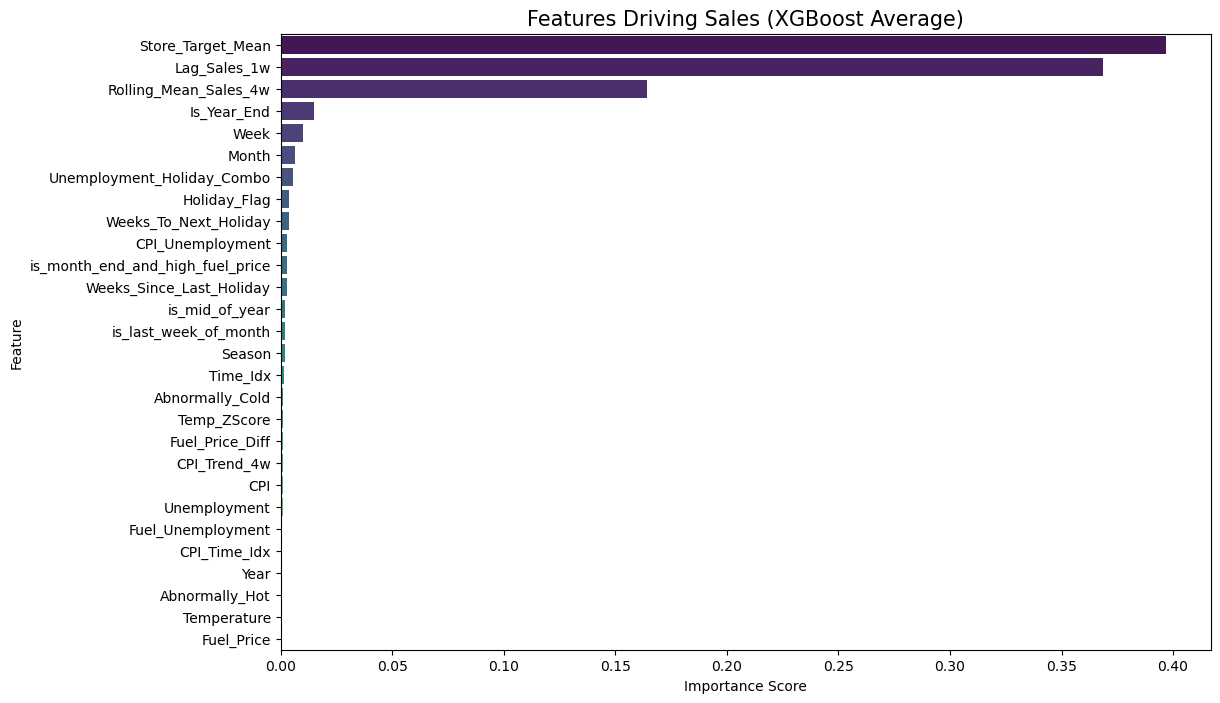

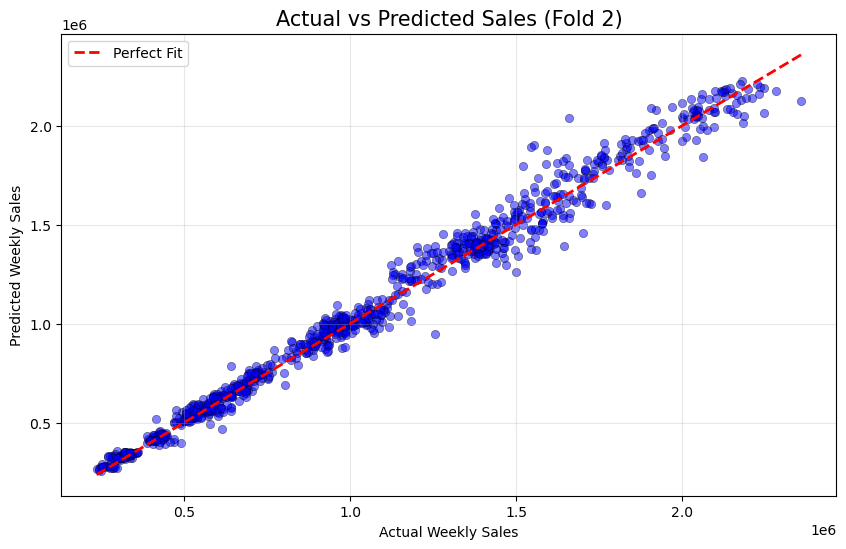

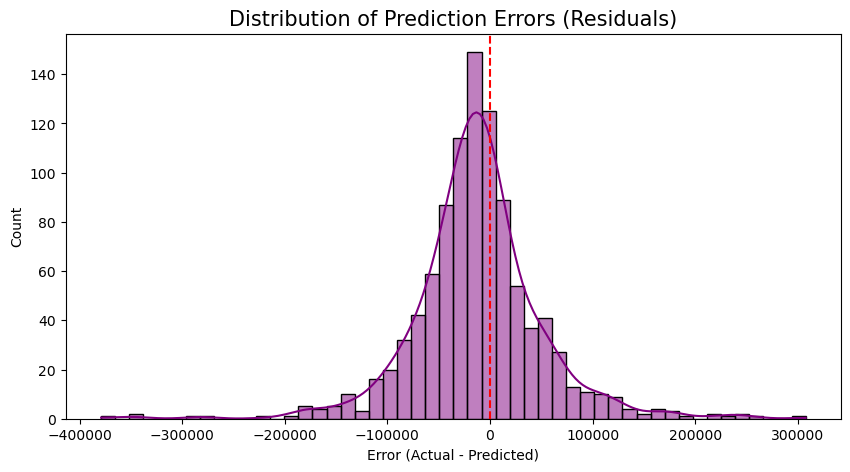

In [10]:
# --- Graph 1: Feature Importance (Aggregated over folds) ---
# Average the feature importance across all folds
avg_importance = np.mean(feature_importance_list, axis=0)
feature_names = X_train.columns

# Create DataFrame for plotting
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': avg_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False) # Top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Features Driving Sales (XGBoost Average)', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# --- Graph 2: Actual vs Predicted (Validation on Last Fold) ---
# We use the data from the last loop iteration
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=preds, alpha=0.5, color='blue', edgecolor='k')

# Add a perfect prediction line (y=x)
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title(f'Actual vs Predicted Sales (Fold {len(metrics_history)})', fontsize=15)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Graph 3: Prediction Errors (Residuals) ---
residuals = y_test - preds
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Distribution of Prediction Errors (Residuals)', fontsize=15)
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(0, color='red', linestyle='--')
plt.show()

### using SHAP to make the model explainable: 
* SHAP summary plot (global importance)
* SHAP values for 1 prediction
* SHAP waterfall plot
* dependence plot of top 5 features 

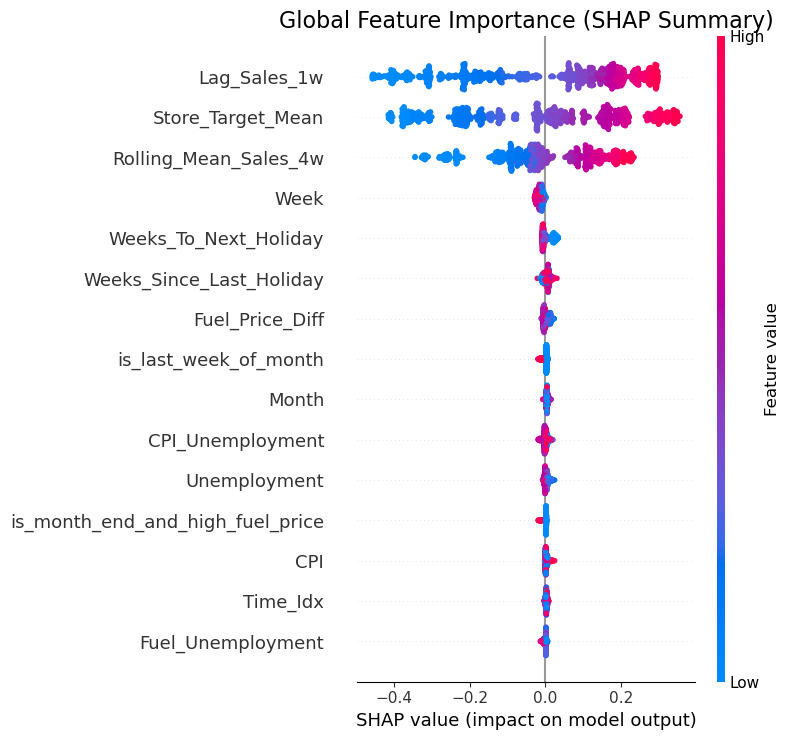


Explaining prediction for index 13:
Actual Sales: 1,582,083.40
Predicted Sales: N/A


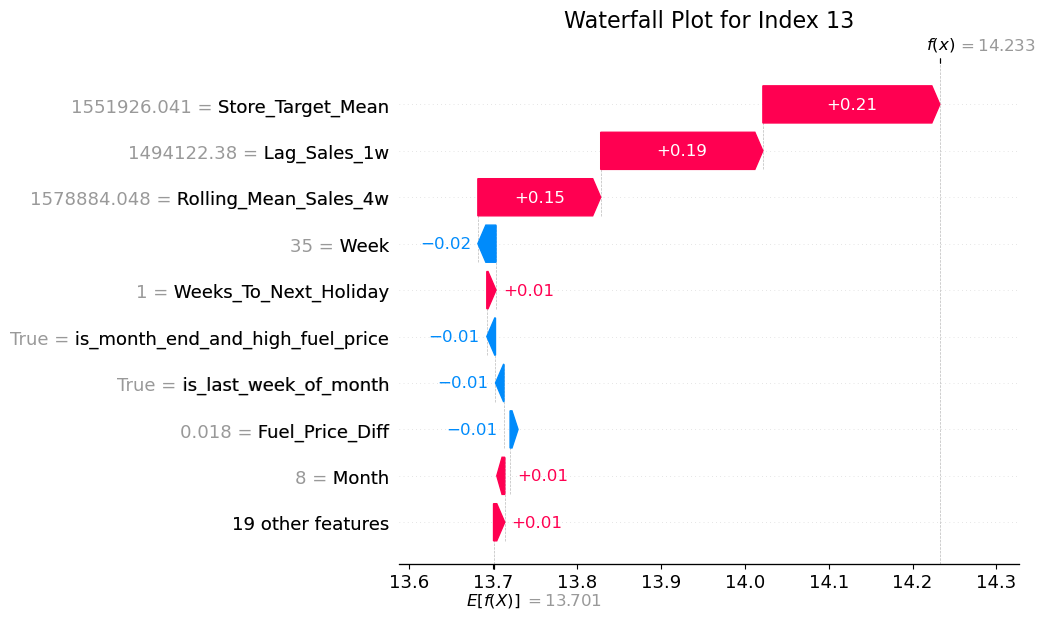


Top 5 Features by SHAP Impact: ['Lag_Sales_1w', 'Store_Target_Mean', 'Rolling_Mean_Sales_4w', 'Week', 'Weeks_To_Next_Holiday']


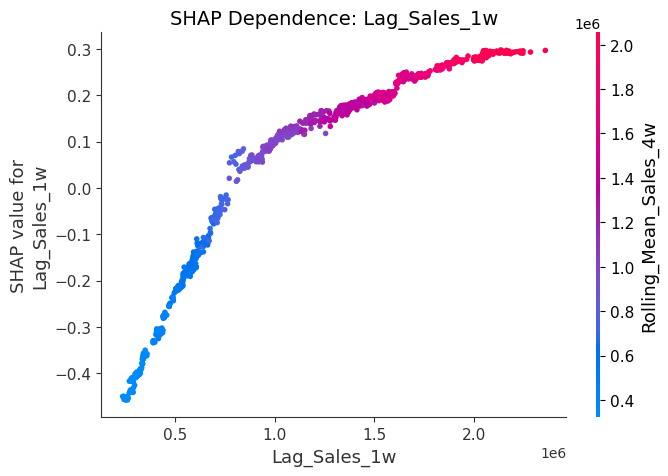

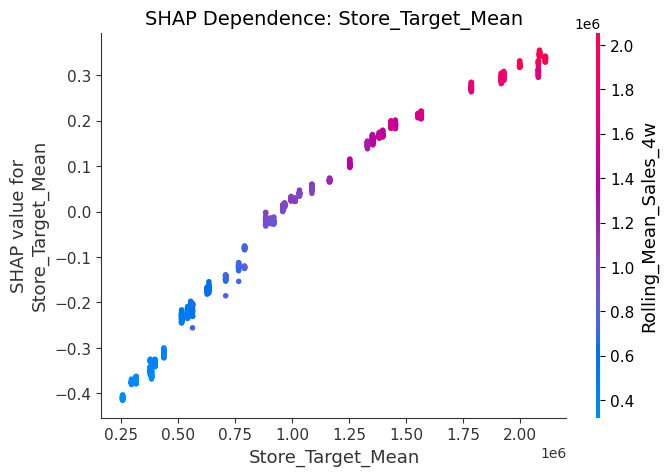

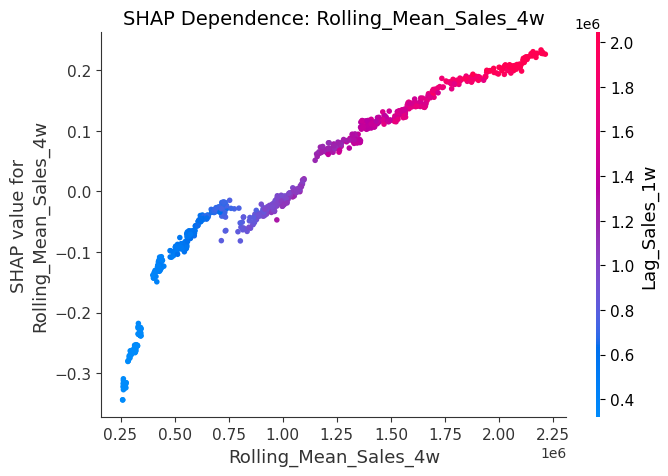

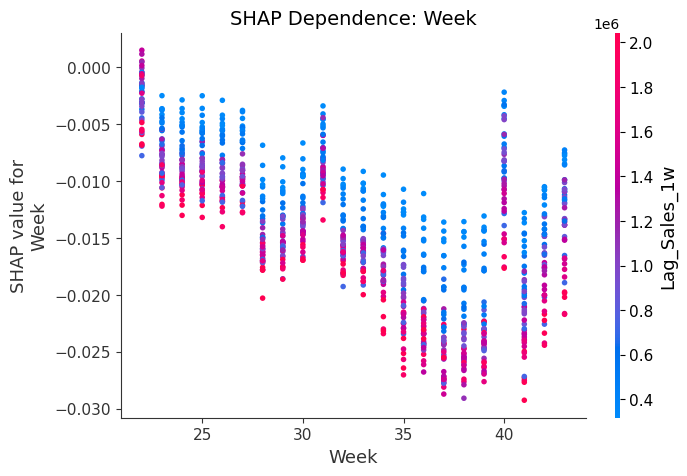

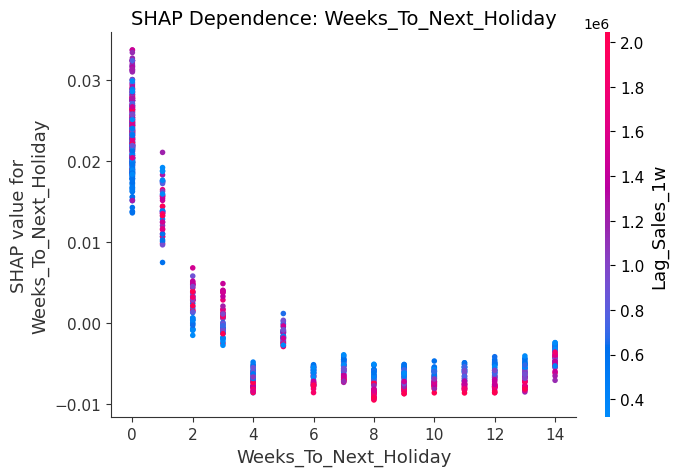

In [11]:

# Initialize JavaScript visualization (needed for some interactive SHAP plots)
shap.initjs()

# 1. Create the Explainer
# XGBoost is a tree-based model, so we use TreeExplainer which is very fast
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# For the modern plots (like waterfall), we need the Explanation object
explanation = explainer(X_test)

# --- 2. SHAP Summary Plot (Global Importance) ---
plt.title("Global Feature Importance (SHAP Summary)", fontsize=16)
# max_display shows top 20 features by default
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.show()

# --- 3. SHAP Waterfall Plot (For 1 Prediction) ---
row_idx = X_test[(X_test['Weeks_To_Next_Holiday'] == 1) & (X_test['Fuel_Price_Diff'] > 0)].index[0]
index_to_explain = X_test.index.get_loc(row_idx)



print(f"\nExplaining prediction for index {index_to_explain}:")
print(f"Actual Sales: {y_test.iloc[index_to_explain]:,.2f}")
print(f"Predicted Sales: {explanation[index_to_explain].data @ model.feature_importances_ if hasattr(model, 'coef_') else 'N/A'}") 
# Note: XGBoost raw output + base_score approximates the prediction

plt.title(f"Waterfall Plot for Index {index_to_explain}", fontsize=16)
shap.plots.waterfall(explanation[index_to_explain])

# --- 4. Dependence Plots for Top 5 Features ---
# Calculate mean absolute SHAP value for each feature to find top 5
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[::-1][:5]
top_features = X_test.columns[top_indices]

print(f"\nTop 5 Features by SHAP Impact: {list(top_features)}")

for feature in top_features:
    # interaction_index='auto' will color by the feature that interacts most with the main feature
    shap.dependence_plot(feature, shap_values, X_test, interaction_index='auto', show=False)
    plt.title(f"SHAP Dependence: {feature}", fontsize=14)
    plt.show()

saving the model and store means

In [12]:
import joblib
import pickle

# Save the trained model
joblib.dump(model, '../data/outputs/model.pkl')

# Save the store_means dictionary
with open('../data/outputs/store_means.pkl', 'wb') as f:
    pickle.dump(store_means, f)


